In [39]:
import librosa, librosa.display, librosa.util
import matplotlib.pyplot as plt
import numpy as np

In [40]:
y, sr = librosa.load('./audio/StarS.wav')
C = np.abs(librosa.cqt(y, sr=sr, hop_length=64, n_bins=84, bins_per_octave=12))

> C - 分音矩阵  
> C.shape - 84个音， 时间帧

In [41]:
type(C)
print(C.shape)

(84, 2765)


# Dimensionality Deduction  
Output: d_C as dimension-deducted C matrix  

Take every 5 frames to 1 using average  
**Time as y_axis, changed from here**  

Calculated after C

In [42]:
d_C = np.zeros([1, C.shape[0]])
local_sum = np.zeros([1, C.shape[0]])
# 84*1


i=0
de_di_rate = 8
for i in range(0, C.shape[1]):
    if (i+1)%de_di_rate != 0:
        local_sum += C[:,i]
    else:
        local_sum /= de_di_rate
        d_C = np.r_[d_C, local_sum]
        local_sum = np.zeros([1, C.shape[0]])
        
if (i+1)%de_di_rate != 0:
    local_sum /= (i+1)%de_di_rate
    d_C = np.r_[d_C, local_sum]

> 检查时间帧顺序，d_C中第一帧的[0]此时可用作参考  

In [43]:
print(d_C)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.46889033e-04 3.09099079e-04 2.86638633e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.41656430e-04 2.04020169e-04 3.81070603e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.00941295e-02 4.90910778e-02 6.19525952e-02 ... 2.11870467e-04
  1.49681798e-04 1.40967303e-04]
 [1.69304798e-02 4.39309508e-02 6.25246722e-02 ... 1.77785982e-04
  1.49263523e-04 1.32263329e-04]
 [1.78174964e-02 4.77499247e-02 7.17333282e-02 ... 1.71373917e-04
  1.01151055e-04 8.19898234e-05]]


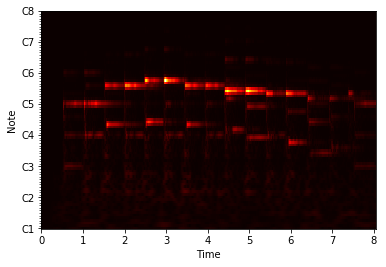

In [44]:
librosa.display.specshow(np.transpose(d_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Denoising  
Output: n_C as normalized C matrix
- Normalization  
- Threshold  

Calculated after d_C

In [45]:
n_C = d_C/np.max(d_C)
SIGMA = 0.1
for i in range(0, n_C.shape[0]):
    for j in range(0, n_C.shape[1]):
        if n_C[i][j] < SIGMA:
            n_C[i][j] = 0
            

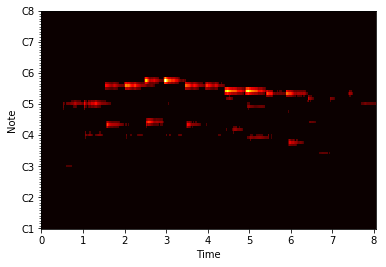

In [46]:
librosa.display.specshow(np.transpose(n_C), sr=sr, x_axis='time', y_axis='cqt_note')
plt.set_cmap('hot')
plt.show()

# Euclidean Distance Calculation  
Output: euclidean distance for frequency vectors of adjacent time frames  

${\Sigma_i{{(x[i]-y[i])}}^2}$  

Calculated after n_C  

In [47]:
print(type(n_C), n_C.shape)

<class 'numpy.ndarray'> (347, 84)


In [48]:
eu_dst = np.zeros([n_C.shape[0] - 1, n_C.shape[1]])
for i in range(0, n_C.shape[0] - 1):
    eu_dst[i] = (n_C[i] - n_C[i+1]) * (n_C[i] - n_C[i+1])

eu_dst = eu_dst.sum(axis = 1)

# Peak Detection  
Output: onset vectors  

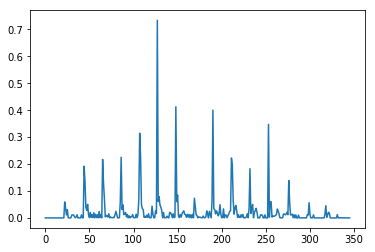

In [49]:
plt.plot(range(0, eu_dst.shape[0]), eu_dst)
plt.show()

# Moving Window Normalization  
Objective: to get a more accurate result of the input distance vector since the volumn are not always the same  
Output: normalized distance vector  

Calculated after the euclidean distance  

## 光滑处理  
双边指数  
